<a href="https://colab.research.google.com/github/fahmiprasanda123/prediks-model-beasiswa/blob/main/Main_beasiswa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sampel Data:
    IPK  Pendapatan_Orang_Tua Asal_Sekolah Lokasi_Sekolah Lokasi_Domisili  \
0  3.06                     4       Negeri           Desa            Kota   
1  3.93                    18       Negeri           Desa       Kabupaten   
2  3.60                     5       Negeri           Kota       Kabupaten   
3  3.40                    16       Swasta           Kota       Kabupaten   
4  2.73                    14       Swasta           Desa       Kabupaten   

   Keikutsertaan_Organisasi  Pengalaman_Sosial Gender Status_Disabilitas  \
0                         0                 20      P              Tidak   
1                         3                 99      L              Tidak   
2                         3                 52      L              Tidak   
3                         2                 44      L              Tidak   
4                         2                 96      P              Tidak   

   Prestasi_Akademik  Prestasi_Non_Akademik  Diterima_Beasiswa  
0 

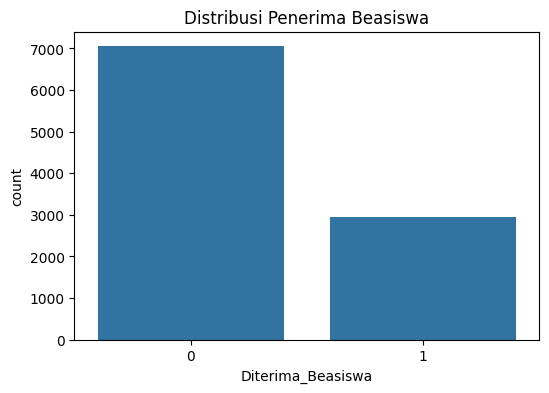


--- Hasil Evaluasi Model ---

Model: Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1396
           1       1.00      0.99      0.99       604

    accuracy                           1.00      2000
   macro avg       1.00      0.99      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Model: Random Forest
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1396
           1       0.99      0.94      0.97       604

    accuracy                           0.98      2000
   macro avg       0.98      0.97      0.98      2000
weighted avg       0.98      0.98      0.98      2000


Model: XGBoost
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1396
           1       0.99      0.99      0.99       604

    accuracy                           0.99      2000
   macro avg       0.99      0.9

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sedang mendownload file ke komputer Anda...


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# ==========================================
# 1. GENERATE DUMMY DATA (Simulasi Dataset)
# ==========================================
# Sesuai deskripsi fitur pada dokumen
np.random.seed(42)
n_samples = 10000

data = {
    'IPK': np.round(np.random.uniform(2.5, 4.0, n_samples), 2),
    'Pendapatan_Orang_Tua': np.random.randint(1, 20, n_samples), # dalam juta
    'Asal_Sekolah': np.random.choice(['Negeri', 'Swasta'], n_samples),
    'Lokasi_Sekolah': np.random.choice(['Kota', 'Desa'], n_samples), # Memecah Kota/Desa dari Asal Sekolah
    'Lokasi_Domisili': np.random.choice(['Kabupaten', 'Kota'], n_samples),
    'Keikutsertaan_Organisasi': np.random.randint(0, 5, n_samples),
    'Pengalaman_Sosial': np.random.randint(0, 100, n_samples), # Jam
    'Gender': np.random.choice(['L', 'P'], n_samples),
    'Status_Disabilitas': np.random.choice(['Ya', 'Tidak'], n_samples, p=[0.05, 0.95]),
    'Prestasi_Akademik': np.random.randint(0, 3, n_samples),
    'Prestasi_Non_Akademik': np.random.randint(0, 3, n_samples)
}

df = pd.DataFrame(data)

# Membuat Label Target (y) secara sintetis dengan logika sederhana
# (Agar model bisa belajar pattern, bukan random noise)
# Logika: IPK tinggi, Pendapatan rendah, dan Prestasi ada -> Peluang diterima tinggi
score = (df['IPK'] * 25) - (df['Pendapatan_Orang_Tua'] * 2) + (df['Prestasi_Akademik'] * 5)
threshold = score.quantile(0.7) # Ambil top 30%
df['Diterima_Beasiswa'] = (score > threshold).astype(int)

print("Sampel Data:")
print(df.head())

# ==========================================
# 2. DATA CLEANING & EDA
# ==========================================
print("\n--- Info Data ---")
print(df.info())

# Cek Missing Values
print("\n--- Missing Values ---")
print(df.isnull().sum())

# Visualisasi Distribusi Target
plt.figure(figsize=(6, 4))
sns.countplot(x='Diterima_Beasiswa', data=df)
plt.title('Distribusi Penerima Beasiswa')
plt.show()

# ==========================================
# 3. PREPROCESSING
# ==========================================
# Memisahkan Fitur (X) dan Target (y)
X = df.drop('Diterima_Beasiswa', axis=1)
y = df['Diterima_Beasiswa']

# Encoding Variabel Kategorikal (One-Hot Encoding)
# Kolom kategorikal: Asal_Sekolah, Lokasi_Sekolah, Lokasi_Domisili, Gender, Status_Disabilitas
categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling (Standarisasi) - Penting terutama untuk Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================
# 4. MODELING
# ==========================================
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

results = []

print("\n--- Hasil Evaluasi Model ---")

for name, model in models.items():
    # Train model
    # Gunakan data scaled untuk Logistic Regression, data biasa ok untuk Tree-based
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Hitung Metrik
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })

    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred))

# ==========================================
#  5. PEMILIHAN MODEL TERBAIK
# ==========================================
results_df = pd.DataFrame(results)
print("\n--- Perbandingan Metrik ---")
print(results_df)

# Menentukan model terbaik berdasarkan F1-Score (Seimbang antara Precision & Recall)
best_model = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]
print(f"\nRekomendasi Model Terbaik: {best_model['Model']}")
print(f"Alasan: Memiliki F1-Score tertinggi ({best_model['F1-Score']:.4f}), menunjukkan keseimbangan terbaik dalam memprediksi pelamar yang diterima dan ditolak.")

# ==========================================
# SIMPAN KE CSV
# ==========================================

# 1. Simpan DataFrame ke file CSV di sistem
nama_file = 'beasiswa_dummy.csv'
df.to_csv(nama_file, index=False) # index=False agar nomor baris (0,1,2..) tidak ikut tersimpan

print(f"File {nama_file} berhasil dibuat!")

# 2. (Khusus Google Colab) Download file ke komputer lokal
try:
    from google.colab import files
    files.download(nama_file)
    print("Sedang mendownload file ke komputer Anda...")
except ImportError:
    print("Jika Anda menjalankan ini di Jupyter Notebook lokal (bukan Colab), file sudah tersimpan di folder yang sama dengan script ini.")